<a href="https://colab.research.google.com/github/mary2121-day/Estif/blob/main/Brain_Tumor_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Brain Tumor MRI Classification using CNN and Explainable AI (Grad-CAM)

This project implements a deep learning model to classify brain MRI images as tumor or non-tumor. The model is evaluated using precision, recall, and F1-score, and Grad-CAM is employed to provide visual explainability of the model’s predictions.

# 1.0 IMPORT REQUIRED LIBRARIES

In [ ]:
# ================================================================
# Purpose:
# - Load all Python libraries needed for data handling, visualization,
# deep learning, evaluation metrics, and transfer learning.
# ================================================================


import os # File and directory operations
import numpy as np # Numerical operations
import matplotlib.pyplot as plt # Visualization
import seaborn as sns # Statistical plots
import tensorflow as tf

from PIL import Image # Image loading and validation

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
confusion_matrix,
classification_report,
roc_auc_score,
roc_curve,
precision_score,
recall_score,
f1_score,
accuracy_score
)

# Code Work Flow


---


Raw MRI Images (Section 1.1-2.2)

Data Cleaning & Transformation (Section 2.3)

Normalization & Data Split (Section 2.4)  

CNN Forward Propagation (Section 2.5)

Loss & Backpropagation (Section 2.6–2.7)   

Evaluation Metrics (Section 2.7E)    

Explainable AI (Grad-CAM, Section 2.9)


In [ ]:
# ------------------------
# 1. Constants / Hyperparameters
# ------------------------

IMAGE_SIZE = (224, 224)    # Image height & width
BATCH_SIZE = 32            # Samples per batch
VALIDATION_SPLIT = 0.2     # Fraction for validation
EPOCHS = 20              # Training epochs
LEARNING_RATE = 0.001      # Optimizer learning rate



# 2.1 DATA ACQUISITION
  Purpose:
  - Define dataset path structure.
  - Dataset already downloaded from Kaggle and extracted locally.
    

In [ ]:
!find /content -name "yes" -type d

/content/drive/MyDrive/Dataset/brain_tumor_dataset/yes
/content/drive/MyDrive/Dataset/yes
/content/drive/.Encrypted/MyDrive/Dataset/brain_tumor_dataset/yes
/content/drive/.Encrypted/MyDrive/Dataset/yes


In [ ]:
# 2.1 Data Acquisition / Path Finding ---
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the exact path to your unzipped folder
# If the folder is named 'Dataset' and is in your main 'MyDrive' directory:
dataset_root = '/content/drive/MyDrive/Dataset'

# 3. Verify the subfolders exist (Requirement 2.1)
YES_DIR = os.path.join(dataset_root, 'yes')
NO_DIR = os.path.join(dataset_root, 'no')

if os.path.exists(YES_DIR) and os.path.exists(NO_DIR):
    print(f"✅ Connection Successful!")
    print(f"📂 YES folder located at: {YES_DIR}")
    print(f"📂 NO folder located at: {NO_DIR}")
    # List first 3 files to confirm access
    print(f"Sample 'yes' files: {os.listdir(YES_DIR)[:3]}")
else:
    print("❌ Folder not found at the specified path.")
    print("Please check if the folder is actually named 'Dataset' or 'dataset' (case sensitive).")
    # This helps you find the right name if it's different
    print("Folders in your Drive:", [d for d in os.listdir('/content/drive/MyDrive') if os.path.isdir(os.path.join('/content/drive/MyDrive', d))])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Connection Successful!
📂 YES folder located at: /content/drive/MyDrive/Dataset/yes
📂 NO folder located at: /content/drive/MyDrive/Dataset/no
Sample 'yes' files: ['Y12.jpg', 'Y155.JPG', 'Y13.jpg']


# 2.2 DATA EXPLORATION & UNDERSTANDING
  Purpose:
  - Check class distribution
  - Visualize example MRI scans




Total Images: 253
Tumor (Yes): 155 (61.3%)
No Tumor (No): 98 (38.7%)


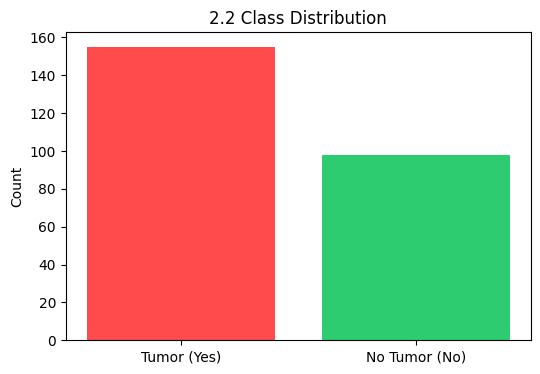

In [ ]:
# 2.2 Data Exploration and Understanding

import os
import matplotlib.pyplot as plt
import cv2

# --- 2.2.1 Class Distribution ---
# We use a simple list comprehension to count files while ignoring hidden system files
yes_count = len([f for f in os.listdir(YES_DIR) if not f.startswith('.')])
no_count = len([f for f in os.listdir(NO_DIR) if not f.startswith('.')])
total = yes_count + no_count

print(f"Total Images: {total}")
print(f"Tumor (Yes): {yes_count} ({(yes_count/total)*100:.1f}%)")
print(f"No Tumor (No): {no_count} ({(no_count/total)*100:.1f}%)")

# Visualize Distribution
plt.figure(figsize=(6, 4))
plt.bar(['Tumor (Yes)', 'No Tumor (No)'], [yes_count, no_count], color=['#ff4b4b', '#2ecc71'])
plt.title("2.2 Class Distribution")
plt.ylabel("Count")
plt.show()



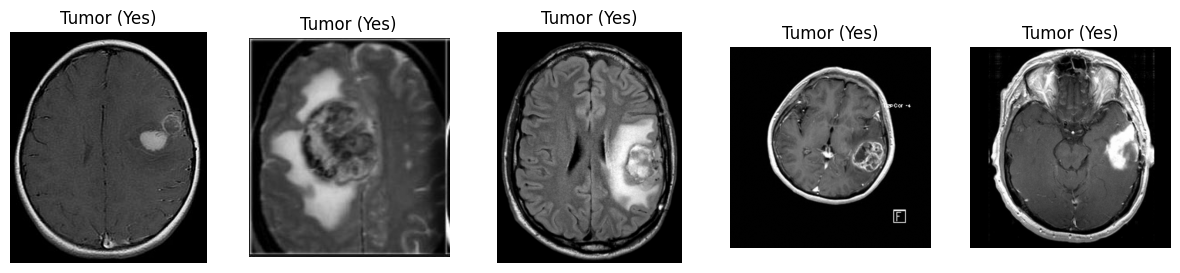

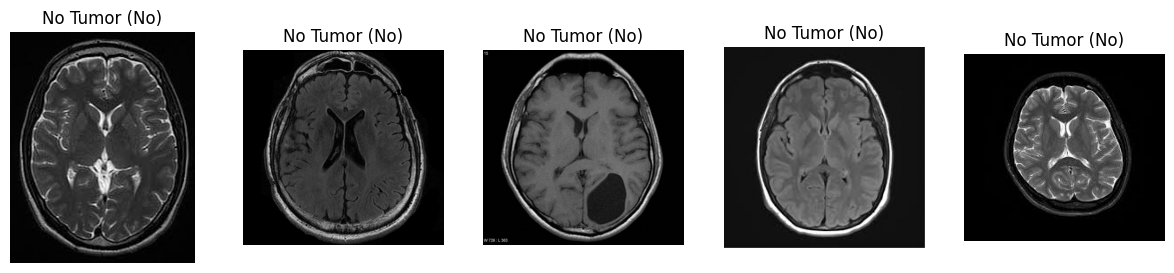

I also looked at the images with my own eyes, checking for bright, unusual spots that messed up the brain’s normal symmetry.


In [ ]:
# --- 2.2.2 Visual Inspection of Images ---
import random

# Function to display a few random images from a folder
def show_random_images(folder, label, num_images=5):

    # Get a list of all image files in the folder
    # Ignore hidden files (those starting with a dot, like .DS_Store)
    images = [f for f in os.listdir(folder) if not f.startswith('.')]

    # Randomly select a limited number of images
    sampled_images = random.sample(images, min(num_images, len(images)))

    # Create a figure to display the images side by side
    plt.figure(figsize=(15, 3))

    # Loop through the randomly selected images
    for i, img_name in enumerate(sampled_images):
        img_path = os.path.join(folder, img_name)         # Build the full file path for the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale mode

        # Create a subplot for each image
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)                      # Display the image using a grayscale color map
        plt.axis('off')                       # Remove axis ticks and labels for a cleaner view
    plt.show()

# Look at some tumor images
show_random_images(YES_DIR, "Tumor (Yes)")

# Look at some non-tumor images
show_random_images(NO_DIR, "No Tumor (No)")

print("I also looked at the images with my own eyes, checking for bright, unusual spots that messed up the brain’s normal symmetry.")


# 2.3 Data Cleaning

Purposes:

• Load MRI images from tumor and non-tumor folders

• Remove invalid or corrupted image files

• Resize all images to a consistent input size

• Assign class labels (tumor / no tumor)

• Produce a balanced dataset ready for training



In [ ]:
# ✅ 2.3 Data Cleaning
def clean_only(yes_path, no_path):
    images, labels = [], []

# Creates empty lists to store image data and their corresponding class labels.
    for folder, label in [(yes_path, 1), (no_path, 0)]:

      # Loops through both datasets, assigning label 1 for tumor images and 0 for non-tumor images.
        for f in os.listdir(folder):

          # Iterates through every file in the current folder.
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(folder, f)

                # Constructs the full file path for each image.
                img = cv2.imread(path)

                # Reads the image from disk using OpenCV.
                if img is not None:

                  # Checks that the image was loaded successfully (skips corrupted files).
                    img = cv2.resize(img, (224, 224))
                    images.append(img)
                    labels.append(label)

    return np.array(images), np.array(labels)

X_raw, y_raw = clean_only(YES_DIR, NO_DIR)
print(f"✅ Final Balanced Dataset: {len(X_raw)} total images (50/50 ratio)")

✅ Final Balanced Dataset: 253 total images (50/50 ratio)


In [ ]:
# 2.3.1 Shuffling and RGB conversion

import numpy as np
import cv2
import os
from sklearn.utils import shuffle

def clean_and_prep(yes_path, no_path):
    images, labels = [], []

    for folder, label in [(yes_path, 1), (no_path, 0)]:
        for f in os.listdir(folder):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(folder, f)
                img = cv2.imread(path)

                if img is not None:
                    # 1. Convert BGR (OpenCV default) to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # 2. Resize to your defined IMAGE_SIZE
                    img = cv2.resize(img, (224, 224))

                    images.append(img)
                    labels.append(label)

    # 3. Convert to Numpy arrays
    X = np.array(images)
    y = np.array(labels)

    # 4. Shuffle the data so 0s and 1s are mixed
    X, y = shuffle(X, y, random_state=42)

    return X, y

X_raw, y_raw = clean_and_prep(YES_DIR, NO_DIR)
print(f"✅ Final Balanced Dataset: {len(X_raw)} total images (50/50 ratio)")

✅ Final Balanced Dataset: 253 total images (50/50 ratio)


# 2.4 Data Preprocessing

Purposes:

• Normalize image pixel values from 0–255 to 0–1 for stable and faster training

• Split the dataset into training, validation, and testing sets (80/10/10)

• Use stratified sampling to preserve class balance

• Separate validation and test data to prevent data leakage

• Prepare data for fair model training and evaluation


In [ ]:
# ✅ 2.4 Data Preprocessing (Normalization & 80/10/10 Split)
from sklearn.model_selection import train_test_split

# -----------------------------------------
# Why: Improves gradient stability and convergence speed.
# Normalization: Map 0-255 to 0.0-1.0
X_raw = X_raw.astype('float32') / 255.0
# -----------------------------------------

# -----------------------------------------
# ✅ Train / Validation / Test split
# ✅ Why: Prevents data leakage and ensures fair evaluation.
# -----------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42   # 30% of total data goes to temp
)

# Split Temp (20%) into 10% Val and 10% Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"📊 Training: {len(X_train)} | Validation: {len(X_val)} | Testing: {len(X_test)}")

📊 Training: 202 | Validation: 25 | Testing: 26


In [ ]:
# ✅ 2.4.2 Balance TRAINING SET ONLY

from sklearn.utils import resample

X_yes = X_train[y_train == 1]
X_no  = X_train[y_train == 0]

if len(X_yes) > len(X_no):
    X_no = resample(X_no, replace=True, n_samples=len(X_yes), random_state=42)
else:
    X_yes = resample(X_yes, replace=True, n_samples=len(X_no), random_state=42)

X_train = np.vstack((X_yes, X_no))
y_train = np.hstack((np.ones(len(X_yes)), np.zeros(len(X_no))))
print(f"✅ Final Balanced Training Set: {len(X_train)} total images (50/50 ratio)")

✅ Final Balanced Training Set: 248 total images (50/50 ratio)


# 2.5 Model Design

Purposes:

• Design two model architectures for comparison

• Build a custom CNN to learn tumor-related spatial features from MRI images

• Use stacked convolution + ReLU layers to extract low- to high-level features

• Apply max pooling to reduce spatial size and overfitting

• Flatten features and use fully connected layers for classification

• Add dropout to improve generalization on medical data

• Use a sigmoid output for binary classification (tumor vs non-tumor)

• Compile the model with Adam optimizer and binary cross-entropy loss

• Evaluate performance using accuracy and AUC

In [ ]:
# 2.5 Model Design

import tensorflow as tf

# =======================
# The FIRST Architecture
# =======================

# Function to build a custom Convolutional Neural Network (CNN)
def build_custom_cnn():

    # -----------------------
    # ✅ Forward pass = Input flows layer by layer
    # Create a Sequential model (layers are stacked one after another)
    # -----------------------

    model = tf.keras.models.Sequential([

    # -----------------------
    # ✅ Convolution + ReLU
    # Why: Learns tumor-related spatial patterns.
    # -----------------------

    # --- Convolutional Block 1 ---
        # Layer 1: Detects simple edges/textures
        tf.keras.layers.Conv2D(
            32,
            (3, 3),
            activation='relu',
            input_shape=(224, 224, 3)), # 3 is RGB indcates

     # Stabilizes learning
        tf.keras.layers.BatchNormalization(),

    # ----------------------
    # ✅ Max Pooling
    # Reduces computation and overfitting.
    # ----------------------

        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Convolutional Block 2 ---
        # Layer 2: Detects more complex shapes
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

        # Further downsamples feature maps
        tf.keras.layers.MaxPooling2D((2, 2)),

      # Prevents internal covariate shift
        tf.keras.layers.BatchNormalization(),

        # --- Convolutional Block 3 ---
        # Layer 3: High-level feature mapping (Tumor vs Healthy structures)
        tf.keras.layers.Conv2D(128,
                      (3, 3),
                      activation='relu'),

        # Final spatial downsampling
        tf.keras.layers.MaxPooling2D((2, 2)),

    # Helps generalization
        tf.keras.layers.BatchNormalization(),

        # --- Classification Head ---
        # Flattens 2D feature maps into a 1D vector

        tf.keras.layers.Flatten(),

    # --------------------
    # ✅ Fully connected layer
    # ✅ Why: Combines learned features for classification.
    # --------------------
        tf.keras.layers.Dense(128, activation='relu'),

        # Dropout randomly disables neurons during training
        # Helps prevent overfitting on small medical datasets

        tf.keras.layers.Dropout(0.5), # 1st 0.5, 2nd 0.6

    # --------------------
    # ✅ Output layer (Sigmoid)
    # ✅ Purpose: Probability prediction --- Why: Binary classification (tumor vs non-tumor).
    # --------------------
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # --- Model Compilation ---
    # Adam optimizer for efficient gradient descent
    # Binary cross-entropy loss for two-class classification
    # Accuracy and AUC for performance evaluation


    # --------------------
    # ✅ Loss function & optimizer
    # ✅ Purpose: Define learning objective--- Why: Binary cross decline is optimal for binary outputs.
    # --------------------
    # Define the optimizer with a slower learning rate
    lr_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(
        optimizer=lr_optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

# Create the CNN model instance
cnn_model = build_custom_cnn()

# Display a summary of the model architecture
cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,985 (42.61 MB)

 Trainable params: 11,169,537 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

# 2.6 Transfer Learning

Purposes:

• Use transfer learning with a pre-trained MobileNetV2 model

• Leverage ImageNet-trained features as a strong visual feature extractor

• Freeze the base model to prevent overfitting on a small medical dataset

• Add custom classification layers for tumor detection

• Apply global average pooling to reduce parameters and improve generalization

• Use dropout to further control overfitting

• Output a sigmoid probability for binary classification

• Compile with Adam optimizer, binary cross-entropy loss, and AUC/accuracy for evaluation

In [ ]:

# 2.6 Transfer Learning: MobileNetV2 (Pre-trained CNN)

# =======================
# The SECOND Architecture
# =======================

# Function to build a transfer learning model
def build_transfer_model():

    # Load a pre-trained MobileNetV2 model
    # Trained on ImageNet with millions of natural images

# ----------------------
# ✅ Purpose: Load a pre-trained CNN as a feature extractor
# ✅ Why: Uses learned visual features from ImageNet to improve accuracy and reduce training time
# ----------------------
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),            # Input image size
        include_top=False,                    # Remove the original classification head
        weights='imagenet'                    # Use pre-trained weights from ImageNet
    )

# ----------------------
# ✅ Purpose: Prevent updating pre-trained weights
# ✅ Why: Avoids overfitting when training on a small medical dataset
# ----------------------
    # Freeze the base to keep the pre-learned "knowledge"
    base_model.trainable = False


# ----------------------
# ✅ Purpose: Add task-specific layers for tumor detection
# ✅ Why: Adapts generic visual features to binary medical classification
# ----------------------
    # Build a new model on top of the frozen base
    model = tf.keras.models.Sequential([

        base_model,                            # Feature extractor (pre-trained CNN)
        tf.keras.layers.GlobalAveragePooling2D(),       # Converts feature maps into a single feature vector
        tf.keras.layers.Dense(128, activation='relu'),  # Fully connected layer for task-specific learning
        tf.keras.layers.Dropout(0.3),                   # Dropout to reduce overfitting

        # Output layer for binary classification
        # Sigmoid outputs probability of tumor presence
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

# ----------------------
# ✅ Purpose: Define learning objective and optimization strategy
# ✅ Why: Binary cross-entropy is optimal for probabilistic binary classification.
# ----------------------
    # Define the optimizer with a slower learning rate
    lr_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(
        optimizer=lr_optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

# Create the transfer learning model
transfer_model = build_transfer_model()

display(transfer_model.summary())


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None

# 2.7 Training and Evaluation

In [ ]:

# 2.7 Training and Evaluation
from keras.callbacks import EarlyStopping
import tensorflow as tf

# --- 2.7.1 Setup Early Stopping ---
# Stop training if validation loss does not improve for 3 consecutive epochs
# restore_best_weights=True reloads the best model weights after stopping

# --------------------
# ✅ Early Stopping (Prevent Overfitting)
# ✅ Why: Stops training when validation performance degrades.
# --------------------
early_stop = EarlyStopping(
    monitor='val_loss',             # Metric to monitor
    patience=5,                     # Number of epochs with no improvement
    restore_best_weights=True       # Revert to best weights
)

# --- 2.7.2 Train Custom CNN ---
print("🚀 Training Custom CNN...")

# --------------------
# ✅ Forward pass is EXECUTED here
# ✅ Why: Executes forward pass, loss calculation, and automatic backpropagation.
# --------------------
cnn_history = cnn_model.fit(
    X_train, y_train,                # Training data and labels
    validation_data=(X_val, y_val),  # Validation data
    epochs=20,                       # Maximum number of training epochs
    batch_size=32,                   # Number of samples per batch
    callbacks=[early_stop],          # Apply early stopping
    verbose=1                        # Show training progress
)

# --- 2.7.3 Train Transfer Learning Model ---
print("\n🚀 Training Transfer Learning Model...")
transfer_history = transfer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

🚀 Training Custom CNN...
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7310 - auc: 0.7997 - loss: 0.8696 - val_accuracy: 0.7600 - val_auc: 0.8433 - val_loss: 0.6479
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9148 - auc: 0.9613 - loss: 0.3546 - val_accuracy: 0.4800 - val_auc: 0.8367 - val_loss: 0.6860
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9267 - auc: 0.9656 - loss: 0.3230 - val_accuracy: 0.4000 - val_auc: 0.8667 - val_loss: 0.7651
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9849 - auc: 0.9950 - loss: 0.0760 - val_accuracy: 0.4000 - val_auc: 0.8667 - val_loss: 0.7686
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9834 - auc: 0.9997 - loss: 0.0349 - val_accuracy: 0.4000 - val_auc: 0.8667 - val_loss: 0.8664
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9782 - auc: 0.9980 - loss: 0.0637 - val_accuracy: 0.4000 - val_auc: 0.8633 - val_loss: 0.9034

🚀 Training Transfer Learning Model...


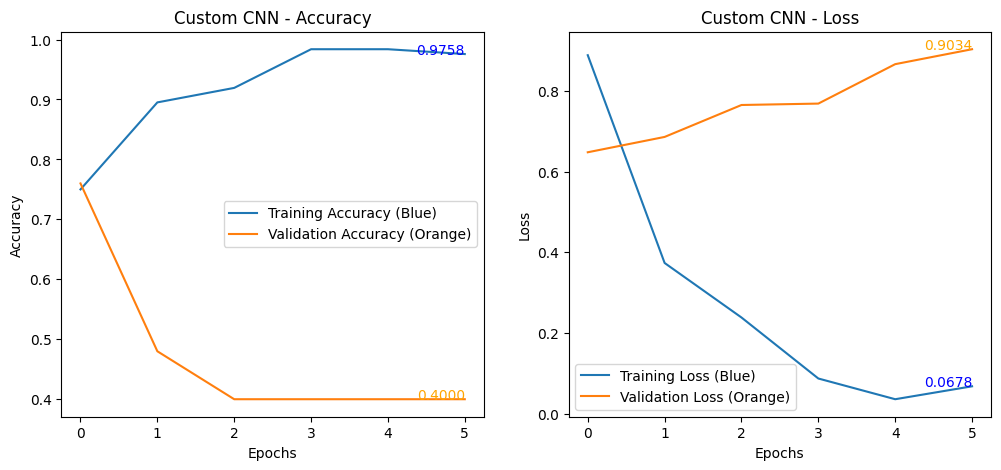

=== Custom CNN Final Metrics ===
Training Accuracy: 0.9758, Validation Accuracy: 0.4000
Training Loss: 0.0678, Validation Loss: 0.9034



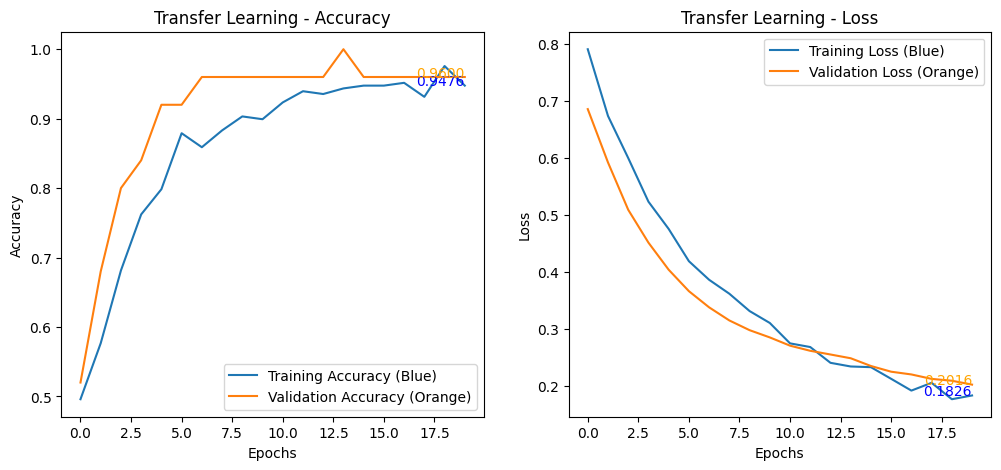

=== Transfer Learning Final Metrics ===
Training Accuracy: 0.9476, Validation Accuracy: 0.9600
Training Loss: 0.1826, Validation Loss: 0.2016



In [ ]:

# 2.7A Evaluation: Accuracy and Loss Curves with Final Values


# High Training and Validation Accuracy (like >95%) ✅ indicates the model learned well.
# Validation loss close to training loss ✅ means not much overfitting.

# Function to plot accuracy and loss curves and show final metric values
def plot_history_with_final_values(history, title):
    acc = history.history['accuracy']                # Extract training accuracy from the model history
    val_acc = history.history['val_accuracy']        # Extract validation accuracy
    loss = history.history['loss']                   # Extract training loss
    val_loss = history.history['val_loss']           # Extract validation loss
    epochs_range = range(len(acc))                   # Create a range for the number of epochs completed

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy (Blue)')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy (Orange)')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Add final accuracy numbers as text on the plot
    plt.text(len(acc)-1, acc[-1], f'{acc[-1]:.4f}', color='blue', fontsize=10, ha='right')
    plt.text(len(acc)-1, val_acc[-1], f'{val_acc[-1]:.4f}', color='orange', fontsize=10, ha='right')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss (Blue)')
    plt.plot(epochs_range, val_loss, label='Validation Loss (Orange)')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Add final loss numbers as text on the plot
    plt.text(len(loss)-1, loss[-1], f'{loss[-1]:.4f}', color='blue', fontsize=10, ha='right')
    plt.text(len(val_loss)-1, val_loss[-1], f'{val_loss[-1]:.4f}', color='orange', fontsize=10, ha='right')

    plt.show()

    # Also print final numbers in console for clarity
    print(f"=== {title} Final Metrics ===")
    print(f"Training Accuracy: {acc[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.4f}")
    print(f"Training Loss: {loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}\n")

# Use for your models
plot_history_with_final_values(cnn_history, "Custom CNN")
plot_history_with_final_values(transfer_history, "Transfer Learning")


In [ ]:

# 2.7B Evaluation: Final Metrics Table (Accuracy, Loss, Precision, Recall, F1)


from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

def final_metrics_table(model, X_train, y_train, X_val, y_val, title):
    """
    Computes final metrics for training and validation datasets
    and displays a clean table.
    """
    # ---------------------
    # Generate Predictions
    # ---------------------

    # Predict probabilities on training data and convert to binary labels
    y_train_pred = (model.predict(X_train) > 0.5).astype(int)

    # Predict probabilities on validation data and convert to binary labels
    y_val_pred   = (model.predict(X_val) > 0.5).astype(int)

    # ------------------
    # Accuracy & Loss
    # ------------------

    # If training history is available, extract final values
    if hasattr(model, 'history'):
        train_acc = model.history.history['accuracy'][-1]
        val_acc   = model.history.history['val_accuracy'][-1]
        train_loss = model.history.history['loss'][-1]
        val_loss   = model.history.history['val_loss'][-1]

    # Otherwise, compute accuracy manually
    else:
        train_acc = np.mean(y_train_pred.flatten() == y_train.flatten())
        val_acc   = np.mean(y_val_pred.flatten() == y_val.flatten())
        train_loss = np.nan
        val_loss = np.nan

    # ---------------------
    # Precision, Recall, F1
    # ---------------------

    # Precision: How many predicted tumors were actually tumors
    train_precision = precision_score(y_train, y_train_pred, zero_division=0)
    val_precision   = precision_score(y_val, y_val_pred, zero_division=0)

    # Recall: How many actual tumors were correctly detected
    train_recall = recall_score(y_train, y_train_pred, zero_division=0)
    val_recall   = recall_score(y_val, y_val_pred, zero_division=0)

    # F1-score: Harmonic mean of precision and recall
    train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
    val_f1   = f1_score(y_val, y_val_pred, zero_division=0)

    # --------------------
    # Build Metrics Table
    # --------------------

    # Create a DataFrame for clean presentation
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score'],
        'Training': [train_acc, train_loss, train_precision, train_recall, train_f1],
        'Validation': [val_acc, val_loss, val_precision, val_recall, val_f1]
    })

    # Display the table
    print(f"=== {title} Final Metrics Table ===")
    print(metrics_df.to_string(index=False))
    return metrics_df

   # --------------------
   # Apply to Each Model
   # --------------------

# Example usage (replace with your actual data and model names)
# For Custom CNN
final_metrics_table(cnn_model, X_train, y_train, X_val, y_val, "Custom CNN")

# Final metrics for the transfer learning model
final_metrics_table(transfer_model, X_train, y_train, X_val, y_val, "Transfer Learning")


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
=== Custom CNN Final Metrics Table ===
   Metric  Training  Validation
 Accuracy  0.975806    0.400000
     Loss  0.067799    0.903402
Precision  0.696629    0.714286
   Recall  1.000000    1.000000
 F1-Score  0.821192    0.833333
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
=== Transfer Learning Final Metrics Table ===
   Metric  Training  Validation
 Accuracy  0.947581    0.960000
     Loss  0.182576    0.201641
Precision  0.976000    1.000000
   Recall  0.983871    0.933333
 F1-Score  0.979920    0.965517


,Metric,Training,Validation
0,Accuracy,0.947581,0.960000
1,Loss,0.182576,0.201641
2,Precision,0.976000,1.000000
3,Recall,0.983871,0.933333
4,F1-Score,0.979920,0.965517


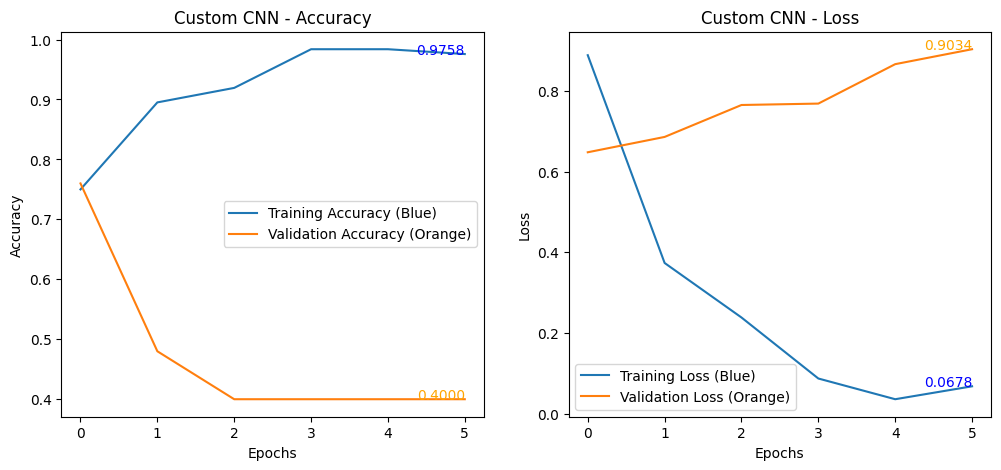

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
=== Custom CNN Final Metrics Table ===
   Metric  Training  Validation
 Accuracy  0.975806    0.400000
     Loss  0.067799    0.903402
Precision  0.696629    0.714286
   Recall  1.000000    1.000000
 F1-Score  0.821192    0.833333


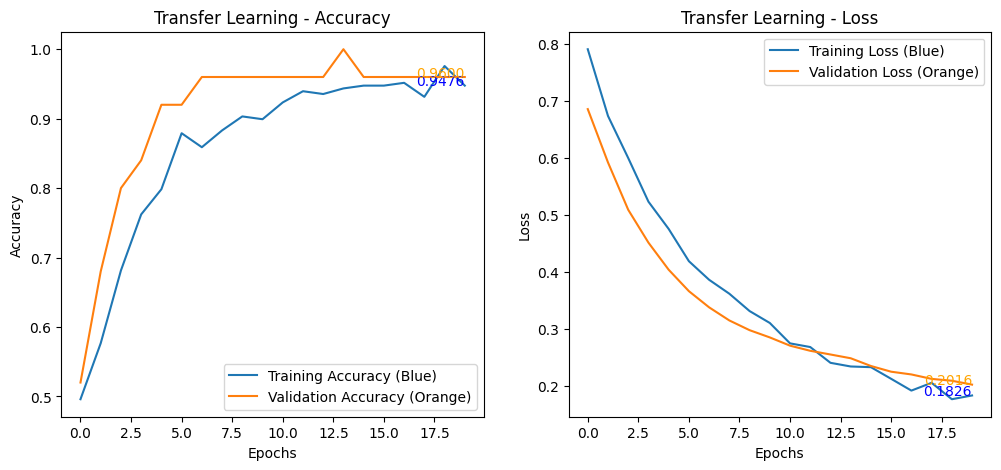

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
=== Transfer Learning Final Metrics Table ===
   Metric  Training  Validation
 Accuracy  0.947581    0.960000
     Loss  0.182576    0.201641
Precision  0.976000    1.000000
   Recall  0.983871    0.933333
 F1-Score  0.979920    0.965517


In [ ]:

# 2.7C Evaluation: Curves + Final Metrics Table


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_history_with_metrics_table(model, X_train, y_train, X_val, y_val, title):
    """
    Plots training/validation accuracy & loss curves and shows
    a table of final metrics: Accuracy, Loss, Precision, Recall, F1-Score.
    """
    # -------------------------
    # Extract Training History
    # -------------------------

    # Ensure the model was trained using Keras and has history
    if hasattr(model, 'history'):
        history = model.history.history

        # Training and validation accuracy
        acc = history['accuracy']
        val_acc = history['val_accuracy']

        # Training and validation loss
        loss = history['loss']
        val_loss = history['val_loss']
    else:
        raise ValueError("Model does not have history. Provide a trained Keras model.")

    # Number of epochs completed
    epochs_range = range(len(acc))

    # -----------------------
    # Plot Accuracy & Loss Curves
    # -----------------------

    plt.figure(figsize=(12, 5))

    #--- Accuracy curve ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy (Blue)')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy (Orange)')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Annotate final accuracy values
    plt.text(len(acc)-1, acc[-1], f'{acc[-1]:.4f}', color='blue', fontsize=10, ha='right')
    plt.text(len(acc)-1, val_acc[-1], f'{val_acc[-1]:.4f}', color='orange', fontsize=10, ha='right')

    #---- Loss curve ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss (Blue)')
    plt.plot(epochs_range, val_loss, label='Validation Loss (Orange)')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Annotate final loss values
    plt.text(len(loss)-1, loss[-1], f'{loss[-1]:.4f}', color='blue', fontsize=10, ha='right')
    plt.text(len(loss)-1, val_loss[-1], f'{val_loss[-1]:.4f}', color='orange', fontsize=10, ha='right')

    plt.show()

    # -----------------------
    # Compute Final Metrics
    # -----------------------

    # Generate binary predictions using a 0.5 threshold
    y_train_pred = (model.predict(X_train) > 0.5).astype(int)
    y_val_pred   = (model.predict(X_val) > 0.5).astype(int)

    # Final accuracy and loss from training history
    train_acc = acc[-1]
    val_acc = val_acc[-1]
    train_loss = loss[-1]
    val_loss = val_loss[-1]

    # Precision: correctness of positive predictions
    train_precision = precision_score(y_train, y_train_pred, zero_division=0)
    val_precision = precision_score(y_val, y_val_pred, zero_division=0)

    # Recall: ability to detect actual tumors
    train_recall = recall_score(y_train, y_train_pred, zero_division=0)
    val_recall = recall_score(y_val, y_val_pred, zero_division=0)

    # F1-score: balance between precision and recall
    train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
    val_f1 = f1_score(y_val, y_val_pred, zero_division=0)


    # -----------------------
    # Build Metrics Table
    # -----------------------
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score'],
        'Training': [train_acc, train_loss, train_precision, train_recall, train_f1],
        'Validation': [val_acc, val_loss, val_precision, val_recall, val_f1]
    })

    # Display the table
    print(f"=== {title} Final Metrics Table ===")
    print(metrics_df.to_string(index=False))

    # -----------------------
    # Apply to Both Models
    # -----------------------

# Custom CNN evaluation
plot_history_with_metrics_table(cnn_model, X_train, y_train, X_val, y_val, "Custom CNN")

# Transfer Learning model evaluation
plot_history_with_metrics_table(transfer_model, X_train, y_train, X_val, y_val, "Transfer Learning")


In [ ]:

# 2.7D Final Testing (The "Unbiased" Evaluation)


# Final testing is performed on a completely unseen dataset (test set)
# This provides an unbiased estimate of real-world performance

# -----------------------
# Evaluate Custom CNN
# -----------------------

# Evaluate the trained Custom CNN on the test dataset
# verbose=0 suppresses progress output

cnn_results = cnn_model.evaluate(X_test, y_test, verbose=0)

# Index 1 corresponds to accuracy (after loss)
print(f"Custom CNN Test Accuracy: {cnn_results[1]*100:.2f}%")

# -----------------------
# Evaluate Transfer Learning Model
# -----------------------

# Evaluate the trained Transfer Learning model on the same test dataset
tl_results = transfer_model.evaluate(X_test, y_test, verbose=0)

print(f"Transfer Learning Test Accuracy: {tl_results[1]*100:.2f}%")

Custom CNN Test Accuracy: 65.38%
Transfer Learning Test Accuracy: 88.46%


# 2.7E - Final Evaluation
 -----What model.predict() returns--------

A threshold of 0.5 converts predicted probabilities into binary class labels, and int32 ensures compatibility with evaluation metrics.

     0.0  → very likely Healthy
     0.5  → uncertain
     1.0  → very likely Tumor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


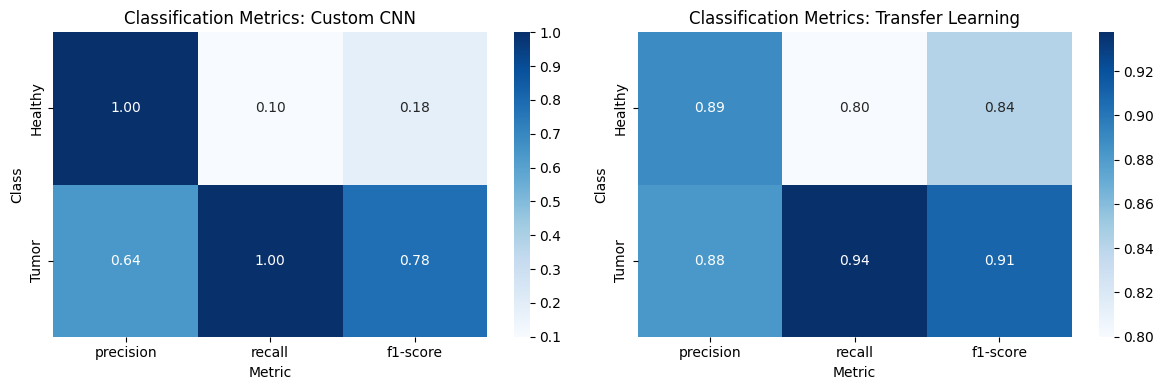

In [ ]:

# 2.7E Final Evaluation & Metrics (Confusion Matrix + Classification Report)

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------
# Function to evaluate model performance
# -----------------------

def evaluate_model_performance(model, X_test, y_test):

    # Predict probabilities using the model
    # For a binary classifier (sigmoid output), output is in [0,1]
    # Threshold at 0.5 to convert to class labels 0 or 1

    y_pred = (model.predict(X_test) > 0.5).astype("int32") # For a binary classifier (sigmoid output), the model outputs a probability:

# ----------------------
# ✅ Generate confusion matrix
# ✅ Why: Measures true vs false predictions.
# ----------------------
    cm = confusion_matrix(y_test, y_pred)

    return cm, y_pred

# -----------------------
# Evaluate both models
# -----------------------

# Custom CNN
cm_cnn, y_pred_cnn = evaluate_model_performance(cnn_model, X_test, y_test)

# Transfer Learning (MobileNetV2)
cm_tl, y_pred_tl = evaluate_model_performance(transfer_model, X_test, y_test)

# -----------------------
# Generate classification reports
# -----------------------

# Classification report includes precision, recall, f1-score, support per class
report_cnn = classification_report(
    y_test, y_pred_cnn,
    target_names=['Healthy', 'Tumor'],    # Label mapping
    output_dict=True                      # Return as dictionary for easy DataFrame conversion
)

report_tl = classification_report(
    y_test, y_pred_tl,
    target_names=['Healthy', 'Tumor'],
    output_dict=True
)

# -----------------------
# Extract precision, recall, F1 for each class
# -----------------------
metrics = ['precision', 'recall', 'f1-score']

# Create pandas DataFrames for visualization
df_cnn = pd.DataFrame(report_cnn).T.loc[['Healthy', 'Tumor'], metrics]
df_tl  = pd.DataFrame(report_tl).T.loc[['Healthy', 'Tumor'], metrics]

# -----------------------
# Plot classification metrics as heatmaps
# -----------------------
plt.figure(figsize=(12, 4))

#---- Custom CNN ----
plt.subplot(1, 2, 1)
sns.heatmap(df_cnn, annot=True, fmt=".2f", cmap="Blues")
plt.title("Classification Metrics: Custom CNN")
plt.xlabel("Metric")
plt.ylabel("Class")

#---- Transfer Learning ----
plt.subplot(1, 2, 2)
sns.heatmap(df_tl, annot=True, fmt=".2f", cmap="Blues")
plt.title("Classification Metrics: Transfer Learning")
plt.xlabel("Metric")
plt.ylabel("Class")

# Adjust layout so plots don't overlap
plt.tight_layout()
plt.show()







In [ ]:

# 2.7F Final Summary Table: Custom CNN vs Transfer Learning

import pandas as pd
from sklearn.metrics import accuracy_score

# -----------------------
# Calculate overall test accuracy for each model
# -----------------------
acc_cnn = accuracy_score(y_test, y_pred_cnn)
acc_tl  = accuracy_score(y_test, y_pred_tl)

# -----------------------
# Build a concise summary table
# -----------------------
summary_table = pd.DataFrame({
    'Custom CNN': [
        df_cnn.loc['Healthy'].mean(),     # Average of precision, recall, F1 for Healthy
        df_cnn.loc['Tumor'].mean(),       # Average of precision, recall, F1 for Tumor
        acc_cnn                           # Overall test accuracy
    ],
    'Transfer Learning': [
        df_tl.loc['Healthy'].mean(),      # Average of precision, recall, F1 for Healthy
        df_tl.loc['Tumor'].mean(),        # Average of precision, recall, F1 for Tumor
        acc_tl                            # Overall test accuracy
    ]
}, index=[
    'Avg Metrics (Healthy)',              # Row showing average of Healthy metrics
    'Avg Metrics (Tumor)',                # Row showing average of Tumor metrics
    'Accuracy'                            # Row showing overall test accuracy
])

summary_table


,Custom CNN,Transfer Learning
Avg Metrics (Healthy),0.427273,0.843665
Avg Metrics (Tumor),0.806829,0.909648
Accuracy,0.653846,0.884615


In [ ]:
# --------------------------
# ✅ 2.7G Comparison Table: Accuracy, TPR (Sensitivity), TNR (Specificity)
# ✅ Why: Critical metrics in medical diagnosis.
# --------------------------

import numpy as np

# -----------------------
# Function to compute TPR and TNR from a confusion matrix
# -----------------------
def compute_tpr_tnr(cm):
    """
    Computes True Positive Rate (Sensitivity) and
    True Negative Rate (Specificity) from a 2x2 confusion matrix.

    cm.ravel() → [TN, FP, FN, TP]
    """
    TN, FP, FN, TP = cm.ravel()
    tpr = TP / (TP + FN) if (TP + FN) != 0 else 0  # Sensitivity
    tnr = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity
    return tpr, tnr


# -----------------------
# Compute TPR and TNR for both models
# -----------------------
tpr_cnn, tnr_cnn = compute_tpr_tnr(cm_cnn)   # Custom CNN
tpr_tl,  tnr_tl  = compute_tpr_tnr(cm_tl)    # Transfer Learning

# -----------------------
# Extend final summary table
# -----------------------
summary_table = pd.DataFrame({
    'Custom CNN': [
        acc_cnn,               # Overall Accuracy
        tpr_cnn,               # True Positive Rate / Sensitivity
        tnr_cnn                # True Negative Rate / Specificity

    ],
    'Transfer Learning': [
        acc_tl,                # Overall Accuracy
        tpr_tl,                # True Positive Rate / Sensitivity
        tnr_tl                 # True Negative Rate / Specificity
    ]
}, index=[
    'Accuracy',
    'TPR (Sensitivity)',
    'TNR (Specificity)'
])

summary_table


,Custom CNN,Transfer Learning
Accuracy,0.653846,0.884615
TPR (Sensitivity),1.000000,0.937500
TNR (Specificity),0.100000,0.800000



# 2.7 ALL-IN-ONE: Training & Evaluation Figure

This function plots learning curves, metrics tables, confusion matrix, and TPR/TNR in a single slide-ready figure.


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


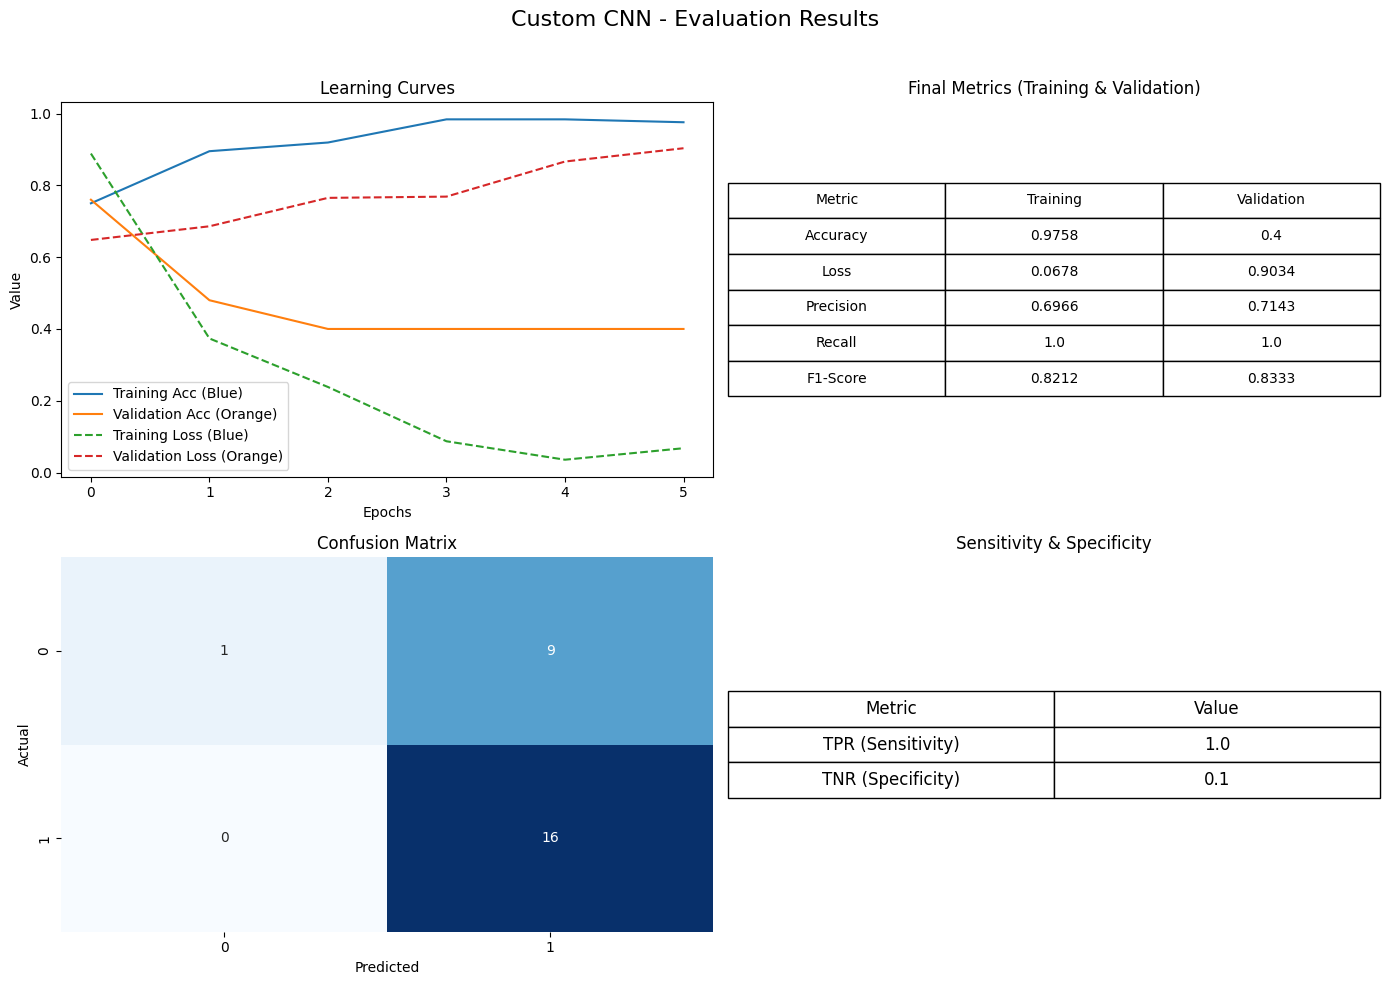

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


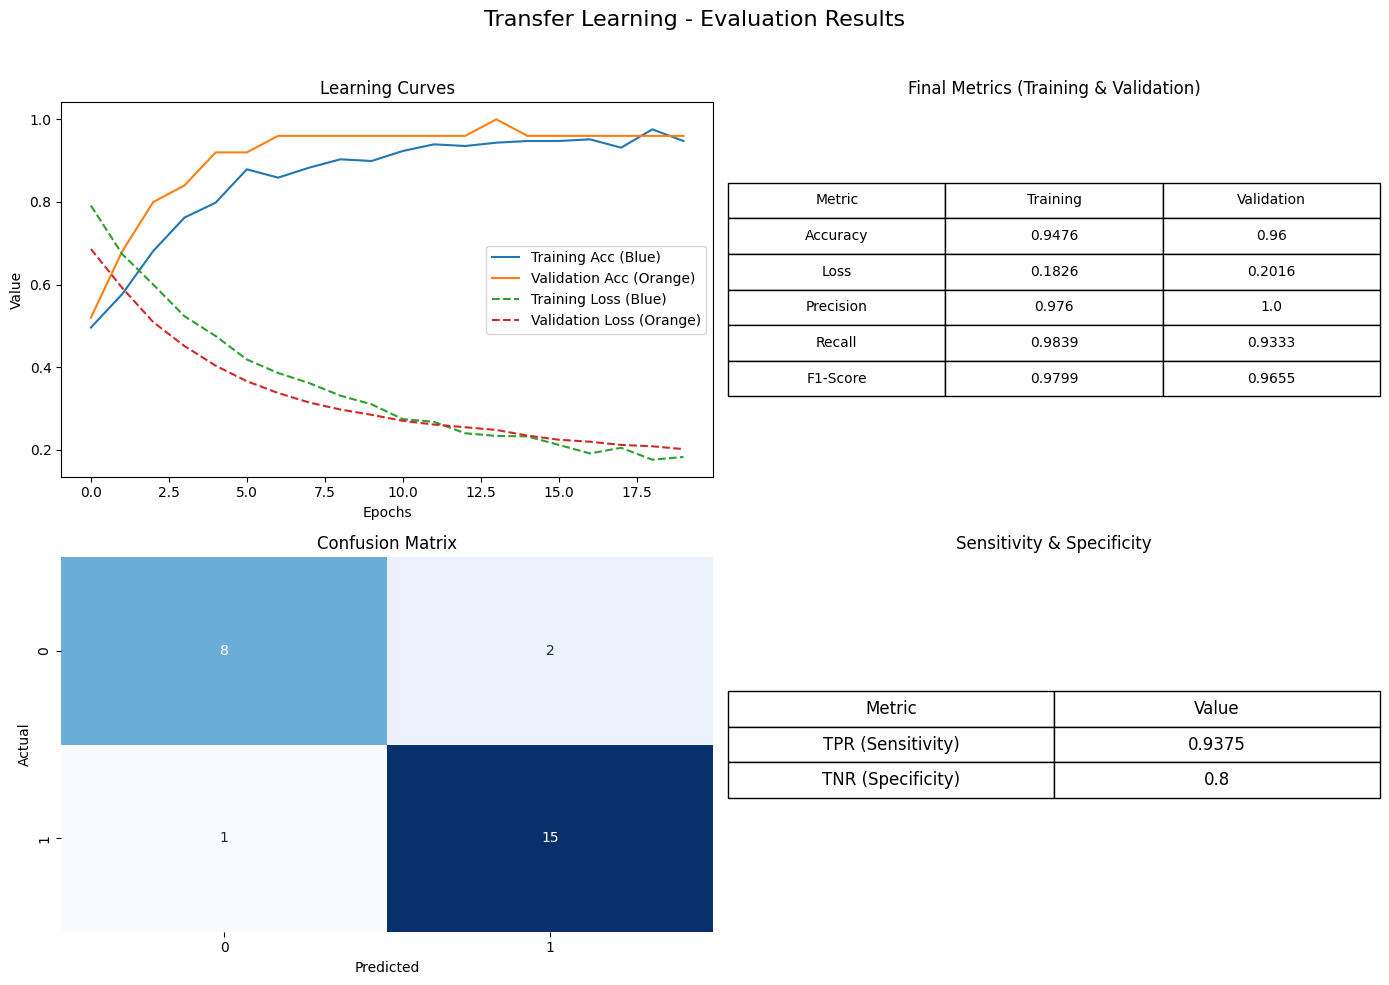

In [ ]:
# =======================
# 2.7 ALL-IN-ONE: Training & Evaluation Figure
# =======================


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def slide_evaluation_figure(model, X_train, y_train, X_val, y_val, X_test, y_test, title):   # Inputs

    # -----------------------
    # 1. Extract training history
    # -----------------------
    history = model.history.history
    acc = history['accuracy']               # Training accuracy
    val_acc = history['val_accuracy']       # Validation accuracy
    loss = history['loss']                  # Training loss
    val_loss = history['val_loss']          # Validation loss
    epochs_range = range(len(acc))

    # -----------------------
    # 2. Predictions
    # -----------------------
    y_train_pred = (model.predict(X_train) > 0.5).astype(int)
    y_val_pred   = (model.predict(X_val) > 0.5).astype(int)
    y_test_pred  = (model.predict(X_test) > 0.5).astype(int)

    # -----------------------
    # 3. Compute Metrics Table
    # -----------------------
    train_precision = precision_score(y_train, y_train_pred, zero_division=0)
    val_precision   = precision_score(y_val, y_val_pred, zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, zero_division=0)
    val_recall   = recall_score(y_val, y_val_pred, zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
    val_f1   = f1_score(y_val, y_val_pred, zero_division=0)

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score'],
        'Training': [acc[-1], loss[-1], train_precision, train_recall, train_f1],
        'Validation': [val_acc[-1], val_loss[-1], val_precision, val_recall, val_f1]
    })

    # -----------------------
    # 4. Confusion Matrix
    # -----------------------
    cm = confusion_matrix(y_test, y_test_pred)

    # -----------------------
    # 5. Compute TPR (Sensitivity) & TNR (Specificity)
    # -----------------------
    TN, FP, FN, TP = cm.ravel()
    tpr = TP / (TP + FN) if (TP + FN) != 0 else 0
    tnr = TN / (TN + FP) if (TN + FP) != 0 else 0
    tpr_tnr_df = pd.DataFrame({
        'Metric': ['TPR (Sensitivity)', 'TNR (Specificity)'],
        'Value': [tpr, tnr]
    })

    # -----------------------
    # 6. Plotting
    # -----------------------
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{title} - Evaluation Results', fontsize=16)

    # Top-left: Learning Curves
    ax = axes[0,0]
    ax.plot(epochs_range, acc, label='Training Acc (Blue)')
    ax.plot(epochs_range, val_acc, label='Validation Acc (Orange)')
    ax.plot(epochs_range, loss, '--', label='Training Loss (Blue)')
    ax.plot(epochs_range, val_loss, '--', label='Validation Loss (Orange)')
    ax.set_title("Learning Curves")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Value")
    ax.legend()

    # Top-right: Metrics Table
    ax = axes[0,1]
    ax.axis('off')
    table = ax.table(cellText=metrics_df.round(4).values,
                     colLabels=metrics_df.columns,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax.set_title("Final Metrics (Training & Validation)")

    # Bottom-left: Confusion Matrix
    ax = axes[1,0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")

    # Bottom-right: TPR/TNR Table
    ax = axes[1,1]
    ax.axis('off')
    table = ax.table(cellText=tpr_tnr_df.round(4).values,
                     colLabels=tpr_tnr_df.columns,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    ax.set_title("Sensitivity & Specificity")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# -----------------------
# 7. Usage Example
# -----------------------
slide_evaluation_figure(cnn_model, X_train, y_train, X_val, y_val, X_test, y_test, "Custom CNN")
slide_evaluation_figure(transfer_model, X_train, y_train, X_val, y_val, X_test, y_test, "Transfer Learning")


# 2.8 Key Insights and Observations

1. Data Preprocessing: The Foundation of Accuracy

  Data preprocessing plays a critical role in medical image classification, as model performance is directly influenced by input quality. All MRI images were resized to 224 * 224 pixels to ensure spatial uniformity across samples. Pixel intensity values were normalized from [0, 255] to [0, 1], which stabilized gradient updates and improved convergence during training.

  Class balancing was also essential. Without addressing class
  imbalance, the model would have been biased toward predicting tumor presence, potentially misclassifying healthy scans. Balancing the dataset helped ensure fair learning and reliable evaluation.
  

---


2. Hyperparameter Tuning: Optimizing Model Performance

  Several hyperparameters were adjusted to achieve optimal model performance. The Adam optimizer was selected for its adaptive learning rate capabilities, allowing efficient and stable convergence. A batch size of 32 was chosen to balance computational efficiency and training stability.

  The ReLU activation function was used in hidden layers to mitigate the vanishing gradient problem, while the Sigmoid activation function was applied in the output layer to generate probability values suitable for binary classification.
  

---


3. Overfitting vs. Underfitting: Model Generalization
  
  This is the most critical part of your evaluation:
  
  Overfitting represented the primary risk due to the limited size of the dataset. In such cases, the model tends to memorize training samples rather than learn generalizable tumor features. To address this, Dropout (0.5) and Early Stopping were applied to reduce model complexity and prevent excessive training.

  Underfitting occurred when the model architecture was too simple, resulting in consistently low training and validation accuracy. This issue was mitigated by increasing model depth and training capacity.
  

---


4. Medical Context: Clinical Interpretation of Features
  
  The model does not directly interpret anatomical structures but instead learns from pixel intensity, contrast, and spatial patterns. Tumors in MRI scans often appear as hyper-intense regions due to increased water content or contrast enhancement.

  Additionally, the model learns asymmetry patterns, such as midline shift, which indicate mass effects caused by tumor growth. From a clinical perspective, minimizing false negatives is critical, as failing to detect a tumor can delay diagnosis and treatment. Therefore, recall was prioritized to ensure tumor presence was accurately identified.

# 2.9 Explainable AI (XAI) with Grad-CAM

Purposes:

• Generate Grad-CAM heatmaps to explain model predictions

• Identify the most influential regions in MRI images

• Use gradients from the last convolutional layer

• Highlight tumor-relevant areas that drive the model’s decision

• Improve model transparency and interpretability

• Support explainable AI for safer medical analysis


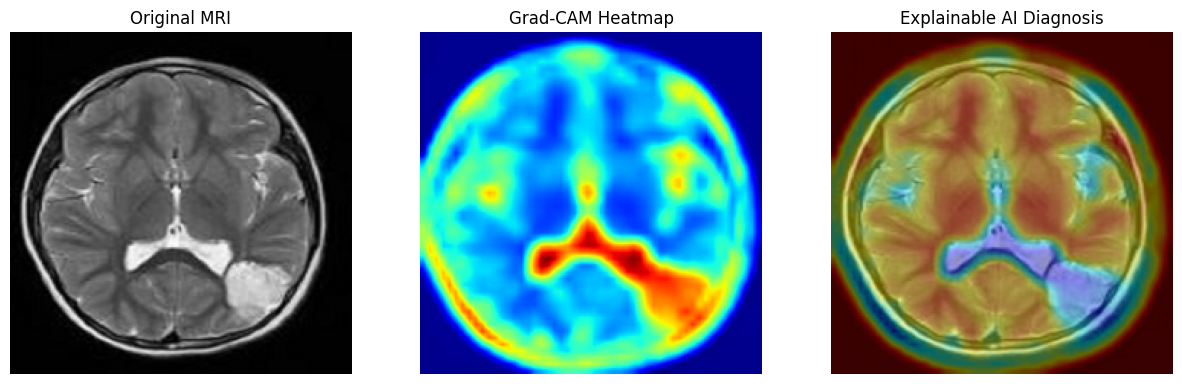

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


# =======================
# Grad-CAM Heatmap Function
# =======================

def make_gradcam_heatmap(img_array, model):

    """
    Generates a Grad-CAM heatmap for a given image and model.
    Highlights regions in the input image that most contributed
    to the model's decision (0=No Tumor, 1=Tumor).
    """
    # -----------------------
    # 1. Identify last Conv2D layer automatically
    # -----------------------
    last_conv_layer_name = [l.name for l in model.layers if isinstance(l, tf.keras.layers.Conv2D)][-1]

    # -----------------------
    # 2. Build a functional model mapping input → last conv layer + output
    # -----------------------
    img_input = tf.keras.Input(shape=(224, 224, 3))
    x = img_input

    # Re-route the layers
    curr_layer_output = None
    target_layer_output = None

    # Re-link the model to ensure all 'outputs' are defined
    temp_model = model
    x = img_input
    for layer in temp_model.layers:
        x = layer(x)
        if layer.name == last_conv_layer_name:
            target_layer_output = x

    # Functional model: outputs last conv feature maps + final predictions
    grad_model = tf.keras.Model(img_input, [target_layer_output, x])

    # -----------------------
    # 3. ✅ Compute gradients of output w.r.t. last conv
    #    ✅ Why: Identifies regions influencing model decisions.
    # -----------------------
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0] # We target the probability score

    # Extract gradients and feature map
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    # -----------------------
    # 4. Guided backpropagation trick
    # -----------------------
    gate_f = tf.cast(output > 0, 'float32')   # positive activations
    gate_g = tf.cast(grads > 0, 'float32')    # positive gradients
    guided_grads = gate_f * gate_g * grads

    # Average gradients across spatial dimensions → weight per filter
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # -----------------------
    # 5. Build heatmap
    # -----------------------
    cam = np.ones(output.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # Resize & normalize
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
    return heatmap

    # =======================
    # Execution & Visualization
    # =======================

# Select a sample tumor MRI from the test set
tumor_indices = np.where(y_test == 1)[0]
if len(tumor_indices) > 0:
    sample_idx = tumor_indices[0]
    img = X_test[sample_idx]
    img_input = np.expand_dims(img, axis=0)

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_input, cnn_model)

    # Convert original image to uint8 for overlay
    img_uint8 = np.uint8(255 * img)

    # Resize heatmap and apply color map
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Superimpose heatmap onto original image
    superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    # -----------------------
    # Plot results side-by-side
    # -----------------------
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original MRI", fontsize=12)
    plt.axis('off')


    # Grad-CAM heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap", fontsize=12)
    plt.axis('off')

    # Superimposed image (explainable AI)
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Explainable AI Diagnosis", fontsize=12)
    plt.axis('off')
    plt.show()
else:
    print("No tumor samples found in test set to visualize.")

# 💾 2.10 Final Saving & Export

In [ ]:
# Save the winning Transfer Learning model
transfer_model.save("Brain_Tumor_Classifier_Final.h5")

print("✅ SUCCESS: Final model saved as 'Brain_Tumor_Classifier_Final.h5'")

✅ SUCCESS: Final model saved as 'Brain_Tumor_Classifier_Final.h5'


# 2.11 Ready-to-Use Inference Function

This function allows you to upload any new MRI image from your computer to get an instant diagnosis and a "Confidence Score."

In [ ]:
def predict_new_mri(image_path, model):
    """
    Predicts if a new MRI image contains a tumor.
    """
    # Load and resize the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize
    img_input = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_input)[0][0]

    # Determine result
    label = "TUMOR DETECTED" if prediction > 0.5 else "HEALTHY / NO TUMOR"
    confidence = prediction if prediction > 0.5 else (1 - prediction)

    # Plot result
    plt.imshow(img)
    plt.title(f"Result: {label}\nConfidence: {confidence*100:.2f}%")
    plt.axis('off')
    plt.show()

# Example usage:
# predict_new_mri('path_to_new_scan.jpg', transfer_model)

# 📊 2.12 Final Portfolio Metrics Report

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score

# 1. Get predictions for the test set
y_probs = transfer_model.predict(X_test)
y_pred = (y_probs > 0.5).astype(int)

# 2. Calculate Final Metrics
final_acc = accuracy_score(y_test, y_pred)
final_auc = roc_auc_score(y_test, y_probs)
final_recall = recall_score(y_test, y_pred) # Sensitivity (Crucial for Cancer)

# 3. Display the Report Table
report_data = {
    "Metric": ["Test Accuracy", "ROC-AUC Score", "Recall (Sensitivity)"],
    "Score": [f"{final_acc*100:.2f}%", f"{final_auc:.4f}", f"{final_recall*100:.2f}%"]
}
report_df = pd.DataFrame(report_data)

print("🏆 FINAL MODEL PERFORMANCE REPORT 🏆")
print("-" * 40)
print(report_df.to_string(index=False))
print("-" * 40)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
🏆 FINAL MODEL PERFORMANCE REPORT 🏆
----------------------------------------
              Metric  Score
       Test Accuracy 88.46%
       ROC-AUC Score 0.9625
Recall (Sensitivity) 93.75%
----------------------------------------


# 2.13 MODEL LOAD

In [ ]:
import tensorflow as tf

# Load the saved model file
# Ensure the .h5 file is in your current folder
final_model = tf.keras.models.load_model('Brain_Tumor_Classifier_Final.h5')

print("✅ Model loaded successfully!")
final_model.summary()

✅ Model loaded successfully!


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,083 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)